In [32]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split 
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from joblib import dump,load

In [2]:
# reading question with text file for wrangling
question_df=pd.read_csv("questions_with_text.csv")
#question_df.info()
# tidy up the city name a bit
question_df['city']=question_df['city'].str.replace(r'[^\w\s]+' ,'')
question_df['city']=question_df['city'].str.lower()# make city name in lowercase


In [3]:
# add new column with city and state together
question_df['class_target']=question_df.city.str.cat(question_df.state ," ")

In [4]:
# get city and state combo that occurs 15+ times
common_cities=question_df.class_target.value_counts()\
    .reset_index(name="count")\
        .query("count>15")["index"]
common_cities_df=question_df[question_df.class_target.isin(common_cities)]
training_data=common_cities_df


In [37]:
dump(common_cities_df.iloc[999] ,"test_case.joblib.dat")

['test_case.joblib.dat']

In [5]:
# remove leaky columns
training_data.drop(['participant_id', 'city' ,'state' ,'zip'], axis=1, inplace=True)




# evaluate model

In [6]:
# convert to label encoding
d = defaultdict(LabelEncoder)
# Encoding the variable
training_data = training_data.apply(lambda x: d[x.name].fit_transform(x))

In [7]:
## export label encoder "d"
dump(d,"label_encoder.joblib.dat")

['label_encoder.joblib.dat']

In [8]:
# train test split
x=training_data.iloc[:,:-1]
y=training_data.class_target
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42 ,shuffle=True)


# KNN

In [9]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(X_train, y_train)
#print(neighbors.predict(X_test))
pred_prob=neighbors.predict_proba(X_test)
pred_label = np.argmax(pred_prob, axis=1)
error_rate = np.sum(pred_label != y_test) / y_test.shape[0]
print('Test error using prob = {}'.format(error_rate))

Test error using prob = 0.9816849816849816


# XGBOOST

In [10]:
# convert to xgboost format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [11]:
# train xgboost model
param = {'max_depth': '6', 'objective':'multi:softprob','num_class': 1862}
#watchlist=[(dtrain,'train'),(dtest,'test')]
num_round=10
eval_set = [(dtest, 'dtest')]
bst = xgb.train(param, dtrain, num_round ,early_stopping_rounds=10, evals=eval_set,verbose_eval=True)
# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
pred_prob = bst.predict(dtest).reshape(y_test.shape[0], 1862)
pred_label = np.argmax(pred_prob, axis=1)
error_rate = np.sum(pred_label != y_test) / y_test.shape[0]
print('Test error using softprob = {}'.format(error_rate))



[21:20:13] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	dtest-mlogloss:5.17184
[1]	dtest-mlogloss:4.88249
[2]	dtest-mlogloss:4.69821
[3]	dtest-mlogloss:4.56709
[4]	dtest-mlogloss:4.46994
[5]	dtest-mlogloss:4.39709
[6]	dtest-mlogloss:4.33783
[7]	dtest-mlogloss:4.29074
[8]	dtest-mlogloss:4.25198
[9]	dtest-mlogloss:4.22010
Test error using softprob = 0.992445054945055


In [12]:
print(bst.best_score, bst.best_iteration,bst.best_ntree_limit)

4.2201 9 10


In [13]:
# export bst model
dump(bst ,"dialect_classifier.joblib.dat")

['dialect_classifier.joblib.dat']

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

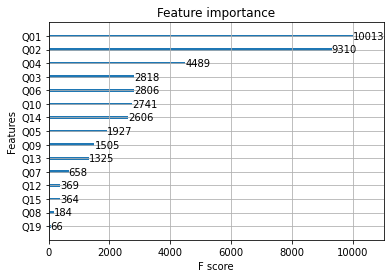

In [15]:
xgb.plot_importance(bst)

TODO

   -  retun top 3 cities+state combo
   - compare naive benchmark (most common class) 
   - export model and encoder
   - convert the user input from rasa form to correct fromat for classifiers
   - return output as text
  


In [14]:
pred_prob=neighbors.predict_proba(X_test)
# indexes of three highest probabilty classes
top_3 = np.argsort(pred_prob, axis=1)[:,-3:]
# top 3 errors
y_test_copy=y_test.reset_index(drop=True)
error_counts=0
for index,value in y_test_copy.items():
    error_counts+=y_test.iloc[index] not in top_3[index]
print("top 3 error" ,error_counts / y_test.shape[0])     


top 3 error 0.9407051282051282


In [15]:
dump(X_test.iloc[999] ,"test_case.joblib.dat")

['test_case.joblib.dat']

In [21]:
# save out classes for each label encoder
encoder_classes={}
for key,value in d.items():
    classes=d[key].classes_
    encoder_classes[key]=classes

In [23]:
dump(encoder_classes ,"encoder_classes.joblib.dat")

['encoder_classes.joblib.dat']

In [35]:
test_case=load("test_case.joblib.dat")

In [36]:
test_case

Q01    7
Q02    6
Q03    0
Q04    5
Q05    4
Q06    1
Q07    0
Q08    1
Q09    0
Q10    3
Q11    2
Q12    0
Q13    2
Q14    1
Q15    2
Q16    1
Q17    0
Q18    3
Q19    2
Q20    2
Q21    0
Q22    3
Q23    2
Q24    1
Name: 34313, dtype: int32

In [38]:
common_cities_df.iloc[999]

Q01                                            youse
Q02                                       doodle bug
Q03                                          freeway
Q04                                    peenie wallie
Q05                                             puma
Q06                                        sneakersn
Q07                                      garage sale
Q08             all three are pronounced differently
Q09                                             both
Q10                                          parkway
Q11                                    rubbernecking
Q12                                        different
Q13                                      crip course
Q14                                       semi-truck
Q15                            with the vowel in jam
Q16                                              pop
Q17                                              sub
Q18                                       party barn
Q19                                         cr

In [33]:
d_classes=load("encoder_classes.joblib.dat")

In [34]:
d_classes

{'Q01': array(['yinz', 'you', 'you all', 'you guys', 'you lot', 'you ’uns',
        'yous', 'youse'], dtype=object),
 'Q02': array(['doodle bug', 'millipede', 'pill bug', 'potato bug', 'roll-up bug',
        'roly poly', 'sow bug', 'twiddle bug', 'wood louse'], dtype=object),
 'Q03': array(['freeway', 'highway', 'parkway', 'turnpike'], dtype=object),
 'Q04': array(['I have no word for this',
        'I use lightning bug and firefly interchangeably', 'firefly',
        'lightning bug', 'others', 'peenie wallie'], dtype=object),
 'Q05': array(['cougar', 'mountain cat', 'mountain lion', 'panther', 'puma'],
       dtype=object),
 'Q06': array(['gym shoes', 'shoes', 'sneakersn'], dtype=object),
 'Q07': array(['garage sale', 'rummage sale', 'tag sale', 'thrift sale',
        'yard sale'], dtype=object),
 'Q08': array(['Mary and merry are pronounced the same, but marry is different',
        'all three are pronounced differently',
        'all three are pronounced the same',
        'merry an